In [1]:
import os
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from tqdm import tqdm
from pprint import pprint

/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.4.1, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
case = 'chb10'
sset = 'Test'
fe = 'PIB'
modelroot = './models' + '/' + case + '/' + fe
model_names = ['SVM_Linear', 'SVM_RBF', 'Logistic_Regression']

root = './data' + '/' + sset + '/' + case
cclass_a = 'Interictal'
cclass_b = 'Preictal'

interictal_dir = './data' + '/' + sset + '/' + case + '/' + cclass_a
preictal_dir = './data' + '/' + sset + '/' + case + '/' + cclass_b
interictal_files = os.listdir(interictal_dir)
preictal_files = os.listdir(preictal_dir)
print(len(interictal_files), interictal_files)
print(len(preictal_files), preictal_files)

12 ['chb10_14_interictal.npy', 'chb10_13_interictal.npy', 'chb10_06_interictal.npy', 'chb10_07_interictal.npy', 'chb10_15_interictal.npy', 'chb10_08_interictal.npy', 'chb10_17_interictal.npy', 'chb10_05_interictal.npy', 'chb10_18_interictal.npy', 'chb10_19_interictal.npy', 'chb10_04_interictal.npy', 'chb10_16_interictal.npy']
3 ['chb10_38_preictal.npy', 'chb10_30_preictal.npy', 'chb10_31_preictal.npy']


In [3]:
# load models
models = []
for i, name in enumerate(tqdm(model_names)):
    modelname = f'{case}_{fe}_{name}'
    modelpath = modelroot + '/' + modelname + '.joblib'
    model = load(modelpath) 
    models.append(model)

100%|██████████| 3/3 [00:00<00:00, 130.42it/s]


In [4]:
interictal_data = []
for i, _ in enumerate(tqdm(interictal_files)):
    # interictal
    filepath = root + '/' + cclass_a + '/' + interictal_files[i]
    data = np.load(filepath)
    interictal_data.append(data)
del data, filepath

100%|██████████| 12/12 [00:01<00:00, 11.33it/s]


In [5]:
preictal_data = []
for i, _ in enumerate(tqdm(preictal_files)):
    # preictal
    filepath = root + '/' + cclass_b + '/' + preictal_files[i]
    data = np.load(filepath)
    preictal_data.append(data)
del data, filepath

100%|██████████| 3/3 [00:00<00:00, 12.68it/s]


In [6]:
interictal_input = np.hstack(interictal_data)
preictal_input = np.hstack(preictal_data)
print('Interictal:', interictal_input.shape, 'Preictal:', preictal_input.shape)
X = np.hstack((interictal_input, preictal_input))
print('All:', X.shape)

Interictal: (23, 2764812) Preictal: (23, 691203)
All: (23, 3456015)


In [7]:
# spectral bandpower parameters
sig = X                                # Feed input signal
fs=256                                 # sampling frequency (Hz)
sliding_window=35                      # stream buffer size for online prediction
N = fs*sliding_window                  # fs = N*fp (N must be a natural number)
n = sig.shape[1]                       # Total number of input samples
fp = fs/N                              # prediction frequency
fft_window='hann'                      # FFT window
fft_window_duration=20                 # FFT sliding window duration (note: this window operates on samples within stream buffer)
band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']                 # neural band names
bands = [(0.1, 4, band_names[0]), (4, 8, band_names[1]), (8, 12, band_names[2]), 
         (12, 30, band_names[3]), (30, 70, band_names[4]), (70, 127.9, band_names[5])]      # neural band definition


print(f'Input length: {n}')
print(f'Input channels: {sig.shape[0]}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
print(f'Stream buffer size: {sliding_window}')
print(f'FFT window: {fft_window}')
print(f'FFT window size: {fft_window_duration}')
print(f'Spectral bands: {bands}')

Input length: 3456015
Input channels: 23
Sampling frequency: 256 Hz
Prediction frequency: 0.02857142857142857 Hz
Stream buffer size: 35
FFT window: hann
FFT window size: 20
Spectral bands: [(0.1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 70, 'Low Gamma'), (70, 127.9, 'High Gamma')]


### Online Prediction of Spectral Bandpower: Linear SVM

In [8]:
model = models[1]
print('Model:', model)
print('Hyperparameters:')
pprint(model.get_params())

Model: SVC(class_weight='balanced', kernel='linear')
Hyperparameters:
{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [9]:
# online prediction

# spectral bandpower history
delta_list = []
theta_list = []
alpha_list = []
beta_list = []
low_gamma_list = []
high_gamma_list = []
bands_mean = []

# prediction history
predict_list = []

# prediciton time history
time_list = []

Ik = N                                      # Stream buffer window width
for _k in tqdm(range(Ik, n), desc='Classifying... '):               
    if (_k % N == 0):                       # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik                   # Starting index of sliding window (end index is maintained by _k)
        x_t = sig[:,w_start:_k]             # Stream buffer window
        df = yasa.bandpower(x_t, sf=fs, win_sec=fft_window_duration, bands=bands, bandpass=True, relative=True, kwargs_welch={'window': fft_window})
        data = df[band_names].to_numpy()
        data_mean = np.mean(data, axis=0)
        prediction = model.predict(data_mean.reshape(1, -1))      # Model prediction
        delta = df[band_names[0]].to_numpy()  # Relative bandpower for all channels
        theta = df[band_names[1]].to_numpy()
        alpha = df[band_names[2]].to_numpy()
        beta = df[band_names[3]].to_numpy()
        low_gamma = df[band_names[4]].to_numpy()
        high_gamma = df[band_names[5]].to_numpy()
        
        delta = np.mean(delta, axis=0)        # Relative bandpower mean across channels
        theta = np.mean(theta, axis=0)
        alpha = np.mean(alpha, axis=0)
        beta = np.mean(beta, axis=0)
        low_gamma = np.mean(low_gamma, axis=0)
        high_gamma = np.mean(high_gamma, axis=0)
        data_mean = np.mean(data_mean, axis=0)
        
        delta_list.append(delta)
        theta_list.append(theta)
        alpha_list.append(alpha)
        beta_list.append(beta)
        low_gamma_list.append(low_gamma)
        high_gamma_list.append(high_gamma)
        bands_mean.append(data_mean)
        
        predict_list.append(prediction)
        time_list.append(_k)
del delta, theta, alpha, beta, low_gamma, high_gamma
delta = np.hstack(delta_list)
theta = np.hstack(theta_list)
alpha = np.hstack(alpha_list)
beta = np.hstack(beta_list)
low_gamma = np.hstack(low_gamma_list)
high_gamma = np.hstack(high_gamma_list)
bands_mean = np.hstack(bands_mean)

predict_sig = np.hstack(predict_list)
predict_times = np.hstack(time_list)

t = np.arange(0, n) / fs / 3600                 # input signal times (h)
k = np.hstack(predict_times)     
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600   # predict signal times (h)

Classifying... : 100%|██████████| 3447055/3447055 [01:05<00:00, 52855.63it/s]


In [10]:
print(delta.shape, theta.shape, alpha.shape, beta.shape, low_gamma.shape, high_gamma.shape, bands_mean.shape)
print(predict_sig.shape)

(385,) (385,) (385,) (385,) (385,) (385,) (385,)
(385,)


In [11]:
t_preictal = np.rint(np.max(np.arange(0, interictal_input.shape[1]) / fs / 3600))
print('Preictal start time (h):', t_preictal)

Preictal start time (h): 3.0


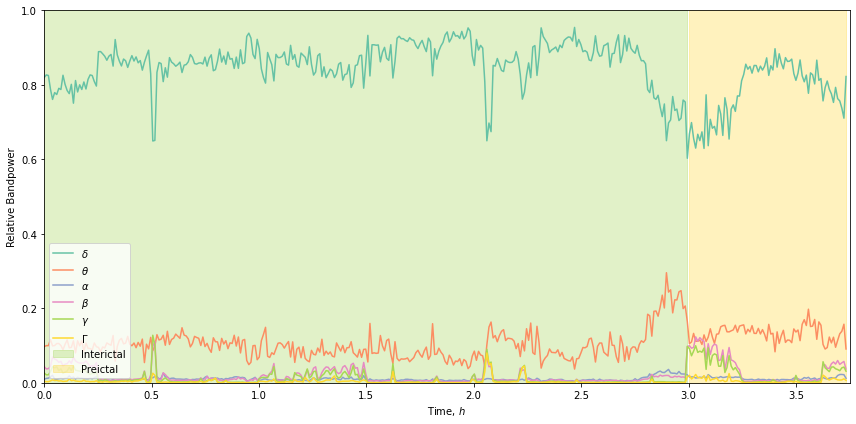

In [12]:
# spectral bandpower response
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))

sns.lineplot(x=pt, y=delta, label=r'$\delta$')
sns.lineplot(x=pt, y=theta, label=r'$\theta$')
sns.lineplot(x=pt, y=alpha, label=r'$\alpha$')
sns.lineplot(x=pt, y=beta, label=r'$\beta$')
sns.lineplot(x=pt, y=low_gamma, label=r'$\gamma$')
ax = sns.lineplot(x=pt, y=high_gamma, label=r'$\Gamma$')
# ax = sns.lineplot(x=pt, y=bands_mean, label=r'Average')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

plt.xlim([0,t.max()])
plt.ylim([0,1])
plt.xlabel('Time, $h$')
plt.ylabel('Relative Bandpower')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig(f'./figures/{case}_{fe}_RT.pdf')
plt.show()

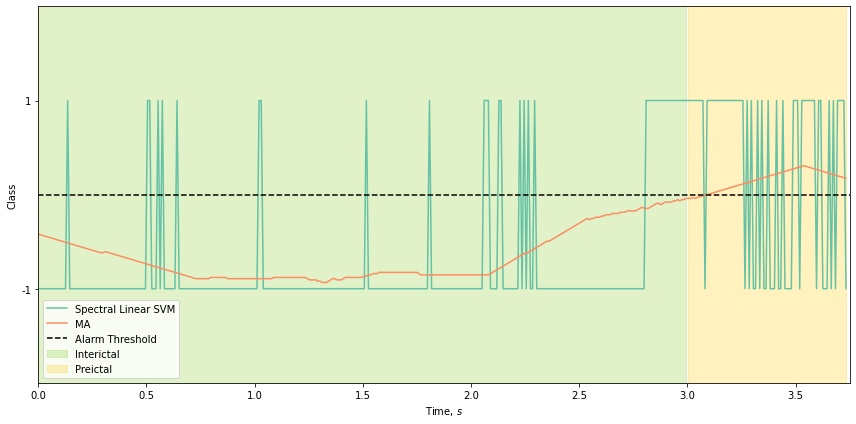

In [13]:
# online classification response
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
m = 150
ma_predict_sig = np.convolve(predict_sig, np.ones(m)/m, mode='same')
sns.lineplot(x=pt, y=predict_sig, label='Spectral Linear SVM')
ax = sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

plt.xlim([0,t.max()])
plt.ylim([-2,2])
plt.xlabel('Time, $s$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig(f'./figures/{case}_{fe}_{model_names[1]}.pdf')
plt.show()

### Online Prediction of Spectral Bandpower: RBF SVM

In [14]:
model = models[0]
print('Model:', model)
print('Hyperparameters:')
pprint(model.get_params())

Model: SVC(class_weight='balanced')
Hyperparameters:
{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [15]:
# online prediction

# spectral bandpower history
delta_list = []
theta_list = []
alpha_list = []
beta_list = []
low_gamma_list = []
high_gamma_list = []
bands_mean = []

# prediction history
predict_list = []

# prediciton time history
time_list = []

Ik = N                                      # Stream buffer window width
for _k in tqdm(range(Ik, n), desc='Classifying... '):               
    if (_k % N == 0):                       # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik                   # Starting index of sliding window (end index is maintained by _k)
        x_t = sig[:,w_start:_k]             # Stream buffer window
        df = yasa.bandpower(x_t, sf=fs, win_sec=fft_window_duration, bands=bands, bandpass=True, relative=True, kwargs_welch={'window': fft_window})
        data = df[band_names].to_numpy()
        data_mean = np.mean(data, axis=0)
        prediction = model.predict(data_mean.reshape(1, -1))      # Model prediction
        delta = df[band_names[0]].to_numpy()  # Relative bandpower for all channels
        theta = df[band_names[1]].to_numpy()
        alpha = df[band_names[2]].to_numpy()
        beta = df[band_names[3]].to_numpy()
        low_gamma = df[band_names[4]].to_numpy()
        high_gamma = df[band_names[5]].to_numpy()
        
        delta = np.mean(delta, axis=0)        # Relative bandpower mean across channels
        theta = np.mean(theta, axis=0)
        alpha = np.mean(alpha, axis=0)
        beta = np.mean(beta, axis=0)
        low_gamma = np.mean(low_gamma, axis=0)
        high_gamma = np.mean(high_gamma, axis=0)
        data_mean = np.mean(data_mean, axis=0)
        
        delta_list.append(delta)
        theta_list.append(theta)
        alpha_list.append(alpha)
        beta_list.append(beta)
        low_gamma_list.append(low_gamma)
        high_gamma_list.append(high_gamma)
        bands_mean.append(data_mean)
        
        predict_list.append(prediction)
        time_list.append(_k)
del delta, theta, alpha, beta, low_gamma, high_gamma
delta = np.hstack(delta_list)
theta = np.hstack(theta_list)
alpha = np.hstack(alpha_list)
beta = np.hstack(beta_list)
low_gamma = np.hstack(low_gamma_list)
high_gamma = np.hstack(high_gamma_list)
bands_mean = np.hstack(bands_mean)

predict_sig = np.hstack(predict_list)
predict_times = np.hstack(time_list)

t = np.arange(0, n) / fs / 3600                 # input signal times (h)
k = np.hstack(predict_times)     
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600   # predict signal times (h)

Classifying... : 100%|██████████| 3447055/3447055 [00:58<00:00, 59404.28it/s]


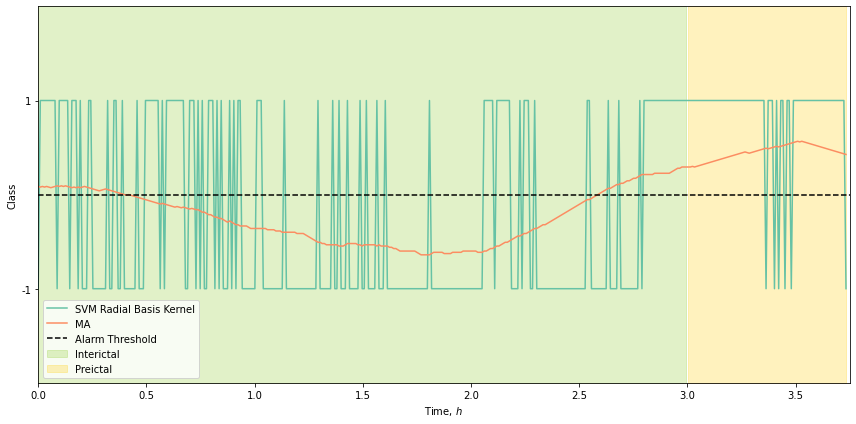

In [16]:
# online classification response
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
m = 150
ma_predict_sig = np.convolve(predict_sig, np.ones(m)/m, mode='same')
sns.lineplot(x=pt, y=predict_sig, label='SVM Radial Basis Kernel')
ax = sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')


tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

plt.xlim([0,t.max()])
plt.ylim([-2,2])
plt.xlabel('Time, $h$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig(f'./figures/{case}_{fe}_{model_names[0]}.pdf')
plt.show()

### Online Prediction of Spectral Bandpower: Logistic Regression

In [17]:
model = models[2]
print('Model:', model)
print('Hyperparameters:')
pprint(model.get_params())

Model: LogisticRegression(random_state=42)
Hyperparameters:
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [18]:
# online prediction

# spectral bandpower history
delta_list = []
theta_list = []
alpha_list = []
beta_list = []
low_gamma_list = []
high_gamma_list = []
bands_mean = []

# prediction history
predict_list = []

# prediciton time history
time_list = []

Ik = N                                      # Stream buffer window width
for _k in tqdm(range(Ik, n), desc='Classifying... '):               
    if (_k % N == 0):                       # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik                   # Starting index of sliding window (end index is maintained by _k)
        x_t = sig[:,w_start:_k]             # Stream buffer window
        df = yasa.bandpower(x_t, sf=fs, win_sec=fft_window_duration, bands=bands, bandpass=True, relative=True, kwargs_welch={'window': fft_window})
        data = df[band_names].to_numpy()
        data_mean = np.mean(data, axis=0)
        prediction = model.predict(data_mean.reshape(1, -1))      # Model prediction
        delta = df[band_names[0]].to_numpy()  # Relative bandpower for all channels
        theta = df[band_names[1]].to_numpy()
        alpha = df[band_names[2]].to_numpy()
        beta = df[band_names[3]].to_numpy()
        low_gamma = df[band_names[4]].to_numpy()
        high_gamma = df[band_names[5]].to_numpy()
        
        delta = np.mean(delta, axis=0)        # Relative bandpower mean across channels
        theta = np.mean(theta, axis=0)
        alpha = np.mean(alpha, axis=0)
        beta = np.mean(beta, axis=0)
        low_gamma = np.mean(low_gamma, axis=0)
        high_gamma = np.mean(high_gamma, axis=0)
        data_mean = np.mean(data_mean, axis=0)
        
        delta_list.append(delta)
        theta_list.append(theta)
        alpha_list.append(alpha)
        beta_list.append(beta)
        low_gamma_list.append(low_gamma)
        high_gamma_list.append(high_gamma)
        bands_mean.append(data_mean)
        
        predict_list.append(prediction)
        time_list.append(_k)
del delta, theta, alpha, beta, low_gamma, high_gamma
delta = np.hstack(delta_list)
theta = np.hstack(theta_list)
alpha = np.hstack(alpha_list)
beta = np.hstack(beta_list)
low_gamma = np.hstack(low_gamma_list)
high_gamma = np.hstack(high_gamma_list)
bands_mean = np.hstack(bands_mean)

predict_sig = np.hstack(predict_list)
predict_times = np.hstack(time_list)

t = np.arange(0, n) / fs / 3600                 # input signal times (h)
k = np.hstack(predict_times)     
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600   # predict signal times (h)

Classifying... : 100%|██████████| 3447055/3447055 [00:48<00:00, 71449.10it/s] 


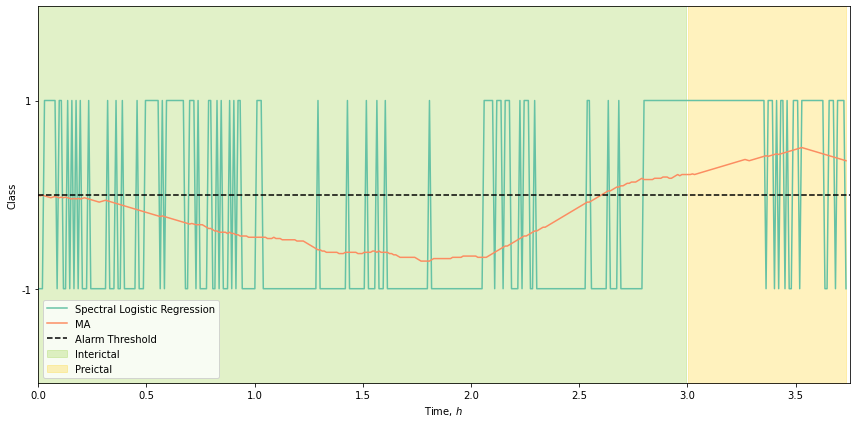

In [19]:
# online classification response
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
m = 150
ma_predict_sig = np.convolve(predict_sig, np.ones(m)/m, mode='same')
sns.lineplot(x=pt, y=predict_sig, label='Spectral Logistic Regression')
ax = sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

plt.xlim([0,t.max()])
plt.ylim([-2,2])
plt.xlabel('Time, $h$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig(f'./figures/{case}_{fe}_{model_names[2]}.pdf')
plt.show()